# Agricultural growth and emissions

- Could we find and support a correlation between greenhouse gas emissions and agricultural growth? Could we also assess the influence of the type of culture on the emissions?
- Based on this, is it possible to make predictions of greenhouse gas emissions by extrapolating the agricultural growth and land usage?
- Is it possible to rank some patterns of land usage with social and environmental factors such as employment, life satisfaction (if data are presents), income inequalities (if data are presents), emissions and finally soil quality and sustainability?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import statsmodels
import folium
import math

# Custom imports
from ipywidgets import IntProgress
from IPython.display import display
import time
from multiprocessing import Pool, Lock
import os
import json
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
dataLands = pd.read_csv("./data/fao_data_land_data.csv")
dataLands

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Afghanistan,11,Area,2007.0,1000 Ha,38661.0,Q,agricultural_area
1,Afghanistan,11,Area,2006.0,1000 Ha,38659.0,Fm,agricultural_area
2,Afghanistan,11,Area,2005.0,1000 Ha,38515.0,Fm,agricultural_area
3,Afghanistan,11,Area,2004.0,1000 Ha,38064.0,Fm,agricultural_area
4,Afghanistan,11,Area,2003.0,1000 Ha,38899.0,Fm,agricultural_area
...,...,...,...,...,...,...,...,...
104779,A,"May include official, semi-official or estimat...",NaN,NaN,NaN,NaN,NaN,total_area_equipped_for_irrigation
104780,F,FAO Estimate,NaN,NaN,NaN,NaN,NaN,total_area_equipped_for_irrigation
104781,Q,Official data reported on FAO Questionnaires f...,NaN,NaN,NaN,NaN,NaN,total_area_equipped_for_irrigation
104782,Fm,Manual Estimation,NaN,NaN,NaN,NaN,NaN,total_area_equipped_for_irrigation


In [3]:
dataLands = dataLands.dropna(subset=["element"])

In [4]:
continents = ["Asia +","Europe +", "Americas +", "Oceania +", "Africa +"]

def cond_countries(dataLands):
    truthTable = (dataLands["country_or_area"] == continents[0])
    print(truthTable)
    for c in continents:
        truthTable = (dataLands["country_or_area"] == c) | truthTable
    return truthTable

#dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
dataLandsContinent = dataLands.where(dataLands["category"] == "agricultural_area")\
                                .where(cond_countries(dataLands))\
                                .dropna(subset=["country_or_area"])\
                                .sort_values("value",ascending=False)

0         False
1         False
2         False
3         False
4         False
          ...  
104771    False
104772    False
104773    False
104774    False
104775    False
Name: country_or_area, Length: 104659, dtype: bool


/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


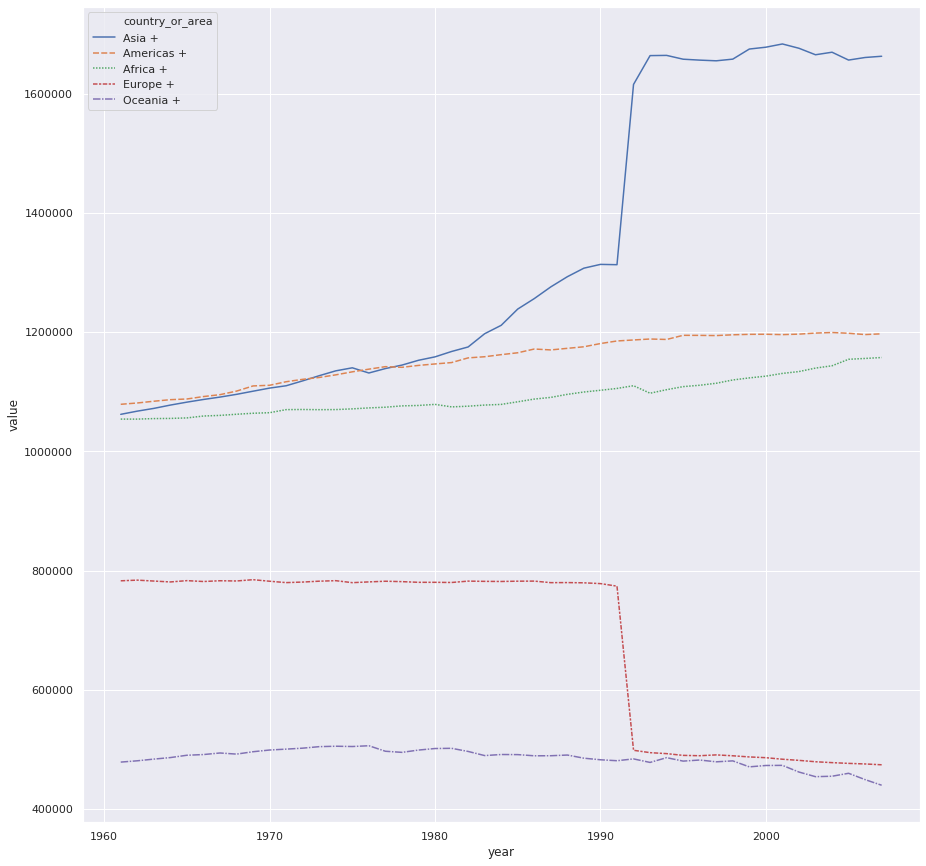

In [5]:
sns.set(style="darkgrid")

fg = plt.figure(figsize=(15,15))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=dataLandsContinent, hue="country_or_area", ax=axes)

fg.show()

Problem with the data between europe and asia. Probably due to fall of Soviet Union.

In [6]:
dataLands["category"].unique()

array(['agricultural_area', 'agricultural_area_irrigated', 'arable_land',
       'arable_land_and_permanent_crops', 'country_area', 'fallow_land',
       'forest_area', 'inland_water', 'land_area', 'other_land',
       'perm_crops_irrigated', 'perm_crops_non_irrigated',
       'perm_meadows_pastures_cult_irrig',
       'perm_meadows_pastures_cult_non_irrig',
       'perm_meadows_pastures_cultivated',
       'perm_meadows_pastures_nat_grown', 'permanent_crops',
       'permanent_meadows_and_pastures', 'temp_crops_irrigated',
       'temp_crops_non_irrigated', 'temp_meadows_pastures_irrigated',
       'temp_meadows_pastures_non_irrig', 'temporary_crops',
       'temporary_meadows_and_pastures',
       'total_area_equipped_for_irrigation'], dtype=object)

In [7]:
dataForest = pd.read_csv("./data/fao_data_forest_data.csv")
dataForest = dataForest.dropna(subset=["element"])
dataForest

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Albania,150,Non-fertilizer use,2007.0,tonnes,0.0,NR,ammonia_anhydrous
1,Albania,150,Non-fertilizer use,2006.0,tonnes,0.0,NR,ammonia_anhydrous
2,Albania,150,Non-fertilizer use,2005.0,tonnes,0.0,NR,ammonia_anhydrous
3,Albania,150,Non-fertilizer use,2004.0,tonnes,0.0,NR,ammonia_anhydrous
4,Albania,150,Non-fertilizer use,2003.0,tonnes,0.0,NR,ammonia_anhydrous
...,...,...,...,...,...,...,...,...
1365139,Zimbabwe,91,Export Quantity,2004.0,tonnes,1857.0,F,wrapping_papers
1365140,Zimbabwe,92,Export Value,2007.0,1000 $,1121.0,F,wrapping_papers
1365141,Zimbabwe,92,Export Value,2006.0,1000 $,1121.0,F,wrapping_papers
1365142,Zimbabwe,92,Export Value,2005.0,1000 $,1121.0,F,wrapping_papers


In [8]:
dataForest.where(dataForest["element"] == "Production in nutrients")["category"].unique()

array([nan, 'nitrogen_n_total_nutrients',
       'phosphate_p205_total_nutrients', 'potash_k20_total_nutrients'],
      dtype=object)

In [9]:
dataCrops = pd.read_csv("./data/fao_data_crops_data.csv")
dataCrops = dataCrops.dropna(subset=["element"])
dataCrops

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes
2,Americas +,31,Area Harvested,2005.0,Ha,49404.0,A,agave_fibres_nes
3,Americas +,31,Area Harvested,2004.0,Ha,49113.0,A,agave_fibres_nes
4,Americas +,31,Area Harvested,2003.0,Ha,48559.0,A,agave_fibres_nes
...,...,...,...,...,...,...,...,...
2255338,World +,51,Production Quantity,1965.0,tonnes,150123.0,A,yautia_cocoyam
2255339,World +,51,Production Quantity,1964.0,tonnes,143203.0,A,yautia_cocoyam
2255340,World +,51,Production Quantity,1963.0,tonnes,142094.0,A,yautia_cocoyam
2255341,World +,51,Production Quantity,1962.0,tonnes,123840.0,A,yautia_cocoyam


In [10]:
wheat = dataCrops.where(dataCrops["element"] == "Area Harvested")\
                    .where(dataCrops["category"].isin(["wheat","bananas"]))\
                    .where(dataCrops["country_or_area"].isin(continents))

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


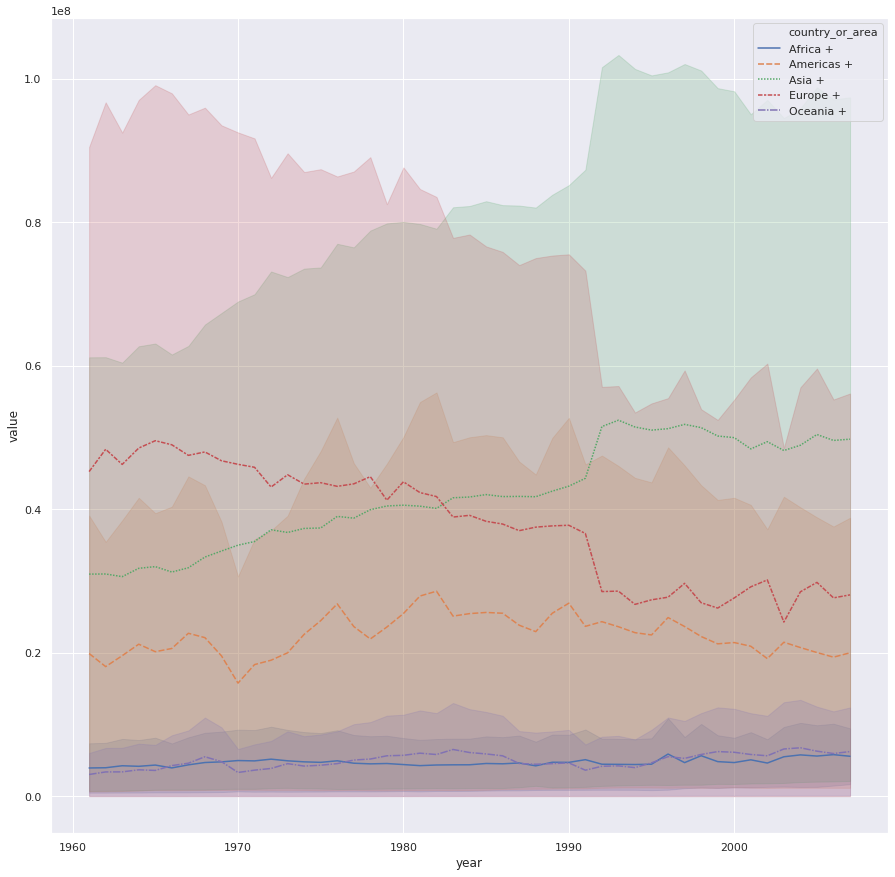

In [11]:
sns.set(style="darkgrid")

fg = plt.figure(figsize=(15,15))
axes = fg.add_subplot()
# Plot the responses for different events and regions
sns.lineplot(x="year", y="value", style="country_or_area", data=wheat, hue="country_or_area", ax=axes)

fg.show()

In [12]:
dataEmissions = pd.read_csv("./data/current_FAO/raw_files/Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv", encoding="cp1252")
#dataEmissions = dataEmissions.dropna(subset=["element"])
dataEmissionsAgriculture = dataEmissions.where(dataEmissions["Item"] == "Agriculture total").where(dataEmissions["Element"] == "Emissions (CO2eq)").dropna()

In [13]:
cropsAndEmissions = dataCrops.drop(["element_code"], axis=1)\
                                .where(dataCrops["element"] == "Area Harvested")\
                                .dropna(subset=["element"])\
                                .drop(["element", "value_footnotes"],axis=1)\
                                .rename(columns={"unit":"Unit area", "value":"Value area", "year":"Year","country_or_area":"Area"})
#                                .where(dataCrops["country_or_area"] == "World +")\
cropsAndEmissions

,Area,Year,Unit area,Value area,category
0,Americas +,2007.0,Ha,49404.0,agave_fibres_nes
1,Americas +,2006.0,Ha,49404.0,agave_fibres_nes
2,Americas +,2005.0,Ha,49404.0,agave_fibres_nes
3,Americas +,2004.0,Ha,49113.0,agave_fibres_nes
4,Americas +,2003.0,Ha,48559.0,agave_fibres_nes
...,...,...,...,...,...
2255244,World +,1965.0,Ha,28896.0,yautia_cocoyam
2255245,World +,1964.0,Ha,27868.0,yautia_cocoyam
2255246,World +,1963.0,Ha,27834.0,yautia_cocoyam
2255247,World +,1962.0,Ha,23871.0,yautia_cocoyam


In [14]:
dataEmissionsAgriculture = dataEmissionsAgriculture.drop(["Item", "Element Code", "Element", "Item Code", "Year Code", "Flag"], axis=1)\
                                                    .rename(columns={"Unit":"Unit emissions","Value":"Value emissions"})
dataEmissionsAgriculture

,Area Code,Area,Year,Unit emissions,Value emissions
1470,2.0,Afghanistan,1990.0,Gigagrams,7.342710e+03
1471,2.0,Afghanistan,1991.0,Gigagrams,7.631027e+03
1472,2.0,Afghanistan,1992.0,Gigagrams,7.631443e+03
1473,2.0,Afghanistan,1993.0,Gigagrams,7.702742e+03
1474,2.0,Afghanistan,1994.0,Gigagrams,7.699139e+03
...,...,...,...,...,...
818728,5873.0,OECD,2006.0,Gigagrams,1.159272e+06
818729,5873.0,OECD,2007.0,Gigagrams,1.158104e+06
818730,5873.0,OECD,2008.0,Gigagrams,1.122836e+06
818731,5873.0,OECD,2009.0,Gigagrams,1.118908e+06


In [15]:
countryURL = "https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json"

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = countryURL
#state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
#state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

#folium.Choropleth(
#    geo_data=state_geo,
#    name='choropleth',
#    data=dataEmissionsAgriculture,
#    columns=['Area', 'Value emissions'],
#    key_on='feature.id',
#    fill_color='YlGn',
#    fill_opacity=0.7,
#    line_opacity=0.2,
#    legend_name='Emissions'
#).add_to(m)


folium.TopoJson(json.loads(requests.get(countryURL).text),
               'objects.countries1',
                name='topojson').add_to(m)

folium.LayerControl().add_to(m)

m

In [16]:
cropsAndEmissions = pd.merge(cropsAndEmissions, dataEmissionsAgriculture, how="left", on=['Area',"Year"])#.dropna(subset=["Value area", "Value emissions"])
cropsAndEmissions = cropsAndEmissions.dropna().dropna(subset=["Unit emissions"])

In [17]:
logistic = LogisticRegression(solver='lbfgs')

features = ["Area","Value emissions"]

X = pd.get_dummies(cropsAndEmissions[features])
y = cropsAndEmissions["category"]

t0 = time.time()
logistic.fit(X, y)
t1 = time.time()

timeElapsed = t1-t0
print(timeElapsed)

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


555.4306039810181


In [18]:
def get_prediction(country, emissions):
    vector = X.iloc[0]
    vector[vector > 0] = 0
    vector["Area_"+country]= 1
    vector["Value emissions"] = emissions
    #print(vector)
    return logistic.predict([vector])

cropsSwitzerland = []
for i in range(50,80):
    cropsSwitzerland.append(get_prediction("Switzerland", math.pow(10,i/10)))

/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/jeremy/miniconda3/envs/ada-2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pyda

In [19]:
cropsSwitzerland

[array(['vegetables_melons_total'], dtype=object),
 array(['vegetables_melons_total'], dtype=object),
 array(['vegetables_melons_total'], dtype=object),
 array(['vegetables_melons_total'], dtype=object),
 array(['cereals_rice_milled_eqv'], dtype=object),
 array(['fibre_crops_primary'], dtype=object),
 array(['fibre_crops_primary'], dtype=object),
 array(['rapeseed'], dtype=object),
 array(['castor_oil_seed'], dtype=object),
 array(['safflower_seed'], dtype=object),
 array(['ramie'], dtype=object),
 array(['ramie'], dtype=object),
 array(['ramie'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['popcorn'], dtype=object),
 array(['po

## IDEA

- Clustering avec les types de crops exportées/récoltées.
- Trouver les crops avec le plus de growth
- Trouver une migration vers le nord